In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, svm
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier, MLPRegressor
from hmmlearn import hmm

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [99]:
df_cus = pd.read_csv('../data/churn_dataset.csv')
df_cus = df_cus.loc[(df_cus.first_order_created_datetime >= "2017-01-01") & (df_cus.last_order_created_datetime < "2018-09-30")]

In [100]:
df_ord = pd.read_csv('../data/order_churn_data.csv')
df_ord = df_ord.merge(df_cus[['customer_db_id', 'completed_orders']], on='customer_db_id', how='left')

In [101]:
df_ord.head().T

,0,1,2,3,4
order_id,DE-A-00034,DE-A-00036,DE-A-00061,DE-A-00093,DE-A-00132
customer_db_id,56b8af2ad2cde8d32d0f0671,578724ecd3cde8ad719cc945,5a1ee6e144770903118b466f,5a81b405447709dd6c8b4617,58d04f7246770953128b4740
order_db_id,57c688d6d4cde8a02a40955c,5ba4a69219207a41d47962df,5b69531a19207a30fd59e8af,5a81b40a4677097f388b4576,5af0b68ec34362325828f24d
order_x,52.5276,52.5395,52.4911,52.488,52.5374
order_y,13.4112,13.4254,13.4297,13.3893,13.3993
pickup_timeslot_from_datetime,2016-08-31 19:00:00,2018-09-24 20:00:00,2018-08-08 09:00:00,2018-02-14 08:00:00,2018-05-09 06:00:00
pickup_timeslot_to_datetime,2016-08-31 21:00:00,2018-09-24 21:00:00,2018-08-08 10:00:00,2018-02-14 09:00:00,2018-05-09 08:00:00
pickup_zip,10178,10435,12047,10965,10115
order_state,completed,completed,completed,completed,completed
order_created_datetime,2016-08-31 09:35:50,2018-09-21 10:06:42,2018-08-07 10:06:50,2018-02-12 16:34:34,2018-05-07 22:26:54


In [102]:
cust_2orders = df_cus.loc[df_cus.completed_orders >= 2]['customer_db_id'].unique().tolist()

In [202]:
df_ord2 = df_ord.loc[(df_ord.customer_db_id.isin(cust_2orders)) & (df_ord.order_state == "completed")]
df_ord2 = df_ord2.sort_values(['customer_db_id', 'order_created_datetime'])

df_ord2['order_comp_num'] = df_ord2.groupby(['customer_db_id']).cumcount()
df_ord2['order_created_datetime'] = pd.to_datetime(df_ord2.order_created_datetime)

df_ord2['next_order_date'] = df_ord2.groupby('customer_db_id')['order_created_datetime'].shift(-1)
df_ord2['last_order_date'] = df_ord2.groupby('customer_db_id')['order_created_datetime'].shift(1)
df_ord2['days_until_next_comp'] = (df_ord2.next_order_date - df_ord2.order_created_datetime).dt.days
df_ord2['days_since_last_comp'] = (df_ord2.order_created_datetime - df_ord2.last_order_date).dt.days

df_ord2['weeks_until_next_comp'] = df_ord2.days_until_next_comp // 7
df_ord2['weeks_since_last_comp'] = df_ord2.days_since_last_comp // 7

df_ord2['last_order_revenue'] = df_ord2.groupby('customer_db_id')['revenue'].shift(1)
df_ord2['last_revenue_diff'] = df_ord2.revenue - df_ord2.last_order_revenue

df_ord2['revenue_brutto'] = df_ord2.revenue + df_ord2.voucher_value

df_ord2 = df_ord2.drop(['next_order_date', 'last_order_date', 'last_order_revenue'], axis=1)

In [203]:
df_ord2 = df_ord2.drop(['cluster', 'cluster_name'], axis=1)
clusters = pd.read_csv('../data/clustering/item_clusters_seasons.csv')
df_ord2 = df_ord2.merge(clusters, on='order_id')

In [204]:
df_ord2 = df_ord2.join(pd.get_dummies(df_ord2['cluster'], prefix='cluster'))
# df_ord2 = df_ord2.join(pd.get_dummies(df_ord2['service_class'], prefix='class'))
# df_ord2 = df_ord2.drop('class_PERSIL', axis=1)

In [205]:
df_ord2.head().T

,0,1,2,3,4
order_id,GB-S-33739,GB-B-78803,GB-H-60995,GB-N-24594,GB-X-29500
customer_db_id,56e8cfd2d4cde8b932bae6a9,56e8cfd2d4cde8b932bae6a9,56e8cfd2d4cde8b932bae6a9,56e8cfd2d4cde8b932bae6a9,571b5744d2cde8e833ff595d
order_db_id,5904c69c4577094a458b45fb,5941223e457709913d8b45c3,59709c45457709413c8b456a,598fa413457709507a8b45c5,58ba8321447709d6158b4592
order_x,51.47,51.47,51.47,51.47,51.5542
order_y,-0.139703,-0.139703,-0.139703,-0.139703,-0.187987
pickup_timeslot_from_datetime,2017-04-30 12:00:00,2017-06-15 10:00:00,2017-07-21 10:30:00,2017-08-14 10:00:00,2017-03-05 08:00:00
pickup_timeslot_to_datetime,2017-04-30 12:30:00,2017-06-15 10:30:00,2017-07-21 11:00:00,2017-08-14 10:30:00,2017-03-05 10:00:00
pickup_zip,SW8 3JD,SW8 3JD,SW8 3JD,SW8 3JD,NW3 7EB
order_state,completed,completed,completed,completed,completed
order_created_datetime,2017-04-29 18:00:12,2017-06-14 12:47:10,2017-07-20 13:04:21,2017-08-13 01:57:55,2017-03-04 09:04:33


In [206]:
df_unknown = df_ord2.loc[(df_ord2.completed_orders == 2) & (df_ord2.order_comp_num == 1)]
df_known = df_ord2.loc[(df_ord2.completed_orders > 2) & (df_ord2.order_comp_num == 1)]

In [207]:
df_known = df_known.loc[df_known.city == 'London']
df_known = df_known.loc[(df_known.days_until_next_comp < 150) & (df_known.days_until_next_comp > 7)]
df_known = df_known.loc[(df_known.days_since_last_comp < 150) & (df_known.days_since_last_comp > 7)]
df_known = df_known.loc[df_known.revenue < 50]

In [208]:
df_known.revenue_brutto.describe()

count    942.000000
mean      25.999818
std       10.204765
min        2.843908
25%       17.183182
50%       24.256045
75%       32.682710
max       65.494957
Name: revenue_brutto, dtype: float64

In [209]:
df_known.gender.value_counts()

male      673
female    266
Name: gender, dtype: int64

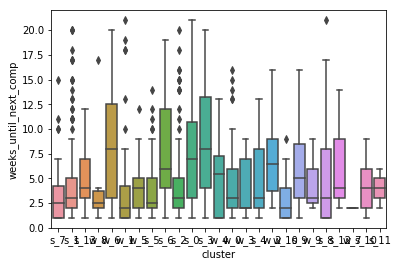

In [210]:
sns.categorical.boxplot(data=df_known, x='cluster', y='weeks_until_next_comp')

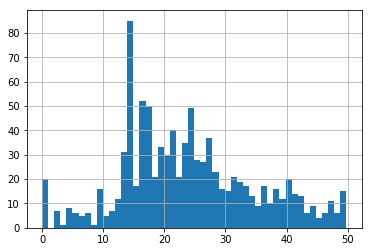

In [211]:
df_known.revenue.hist(bins=50)

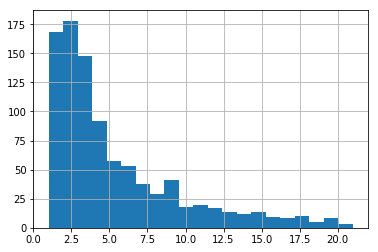

In [212]:
df_known.weeks_until_next_comp.hist(bins=df_known.weeks_until_next_comp.nunique())

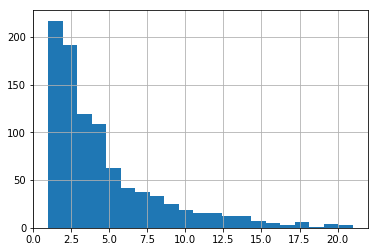

In [213]:
df_known.weeks_since_last_comp.hist(bins=df_known.weeks_since_last_comp.nunique())

In [180]:
df_known.shape

(942, 102)

In [181]:
df_known.loc[df_known.weeks_until_next_comp == 0].T

,109,171,238,272,595,715,818,896,1015,1307,...,19081,19298,19320,19356,19376,19387,19408,19565,19586,19645
order_id,GB-F-62708,GB-A-52548,GB-R-62960,GB-K-65504,GB-R-39014,GB-N-93249,GB-M-08627,GB-X-24138,GB-R-54471,GB-C-26943,...,GB-W-93710,GB-M-28179,GB-E-92044,GB-L-53389,GB-H-90873,GB-M-00287,GB-L-32036,GB-M-21908,GB-M-21130,GB-P-05563
customer_db_id,586a55a3447709f21f8b45b2,586a970a467709dc628b4623,586c07be447709cd6c8b46b5,586cb22c467709ea3a8b45b2,5871fe8b467709b87a8b468f,5873526146770977328b4642,5873d3ba46770907488b45d2,58754f5045770918088b4683,587745184477094d6a8b45a9,587a287144770919678b458c,...,5999d3e9457709014c8b4670,59a576fe457709fe328b462e,59a6c29c467709854d8b45bc,59a992e345770948198b458f,59ab1ec1467709ee198b4607,59abef11447709b9468b4715,59ad32ca457709e03e8b459a,59b662a2457709c3638b46ba,59b7dbdb467709136b8b4715,59bccdef45770960198b4678
order_db_id,588f50c74677096d3d8b4655,58ce7675457709e3588b463c,5895d400457709e94d8b45c2,587cf876447709485d8b4609,590ee77c45770912668b45e1,5891e7dd46770977258b45e2,588510504477090d388b462b,58837ca5457709f1118b4629,589bbccb4677099e238b4572,588b92fb4477092e498b4697,...,59aa5aff447709506b8b46b6,59b64932467709e12a8b464a,59b95b03447709db188b4603,59ba78b64677091d7c8b4569,59c1687b467709c4428b4662,59c0c76a457709a7568b4676,59bba7184677092d348b45ca,59ceade244770950128b45fa,59cbc374467709af228b4655,59c79c05467709da588b461d
order_x,51.4978,51.4608,51.5683,51.5163,51.518,51.5148,51.4912,51.4582,51.5048,51.5009,...,51.5165,51.4983,51.4979,51.5194,51.511,51.5414,51.5115,51.5207,51.5165,51.501
order_y,-0.0909853,-0.19851,-0.13392,-0.179688,-0.0753704,-0.099117,-0.170871,-0.205108,-0.0186222,-0.104171,...,-0.074298,-0.179893,-0.228605,-0.0527366,-0.0960099,-0.175708,-0.107782,-0.176795,-0.163139,-0.0371114
pickup_timeslot_from_datetime,2017-01-30 21:30:00,2017-03-19 20:00:00,2017-02-05 20:00:00,2017-01-16 20:00:00,2017-05-07 18:30:00,2017-02-01 16:00:00,2017-01-23 09:00:00,2017-01-23 07:00:00,2017-02-09 10:30:00,2017-01-28 10:00:00,...,2017-09-03 08:30:00,2017-09-12 18:00:00,2017-09-14 19:30:00,2017-09-14 18:00:00,2017-09-21 19:30:00,2017-09-20 07:30:00,2017-09-18 10:00:00,2017-10-01 09:00:00,2017-09-28 14:00:00,2017-09-28 19:00:00
pickup_timeslot_to_datetime,2017-01-30 22:00:00,2017-03-19 22:00:00,2017-02-05 22:00:00,2017-01-16 22:00:00,2017-05-07 19:00:00,2017-02-01 18:00:00,2017-01-23 11:00:00,2017-01-23 07:30:00,2017-02-09 11:00:00,2017-01-28 12:00:00,...,2017-09-03 09:00:00,2017-09-12 18:30:00,2017-09-14 20:00:00,2017-09-14 20:00:00,2017-09-21 21:30:00,2017-09-20 09:30:00,2017-09-18 12:00:00,2017-10-01 11:00:00,2017-09-28 16:00:00,2017-09-28 21:00:00
pickup_zip,SE1 6QP,SW18 1NL,N19 3RA,W2 6QT,E1 7NZ,EC4M 7DX,SW3 6QD,SW15 2QT,E14 5AB,SE1 0RQ,...,E1,SW7 5JA,W6 0AJ,E1 3AQ,EC4V 3PN,NW8 0SG,EC4Y 0HB,W2 1SU,W1H 5LB,SE16 6BB
order_state,completed,completed,completed,completed,completed,completed,completed,completed,completed,completed,...,completed,completed,completed,completed,completed,completed,completed,completed,completed,completed
order_created_datetime,2017-01-30 14:42:15,2017-03-19 12:15:49,2017-02-04 13:15:44,2017-01-16 16:44:38,2017-05-07 10:23:08,2017-02-01 13:51:25,2017-01-22 20:04:32,2017-01-21 15:22:13,2017-02-09 00:50:19,2017-01-27 18:35:39,...,2017-09-02 08:17:19,2017-09-11 09:28:34,2017-09-13 17:21:23,2017-09-14 13:40:22,2017-09-19 19:56:59,2017-09-19 08:29:46,2017-09-15 11:10:32,2017-09-29 21:32:34,2017-09-27 16:27:48,2017-09-24 12:50:29


# Predictions

In [185]:
feats = ['gender', 'revenue_brutto', 'weeks_since_last_comp'] + df_known.columns[-25:].tolist()
feats

['gender',
 'revenue_brutto',
 'weeks_since_last_comp',
 'cluster_s_0',
 'cluster_s_1',
 'cluster_s_10',
 'cluster_s_11',
 'cluster_s_12',
 'cluster_s_13',
 'cluster_s_2',
 'cluster_s_3',
 'cluster_s_4',
 'cluster_s_5',
 'cluster_s_6',
 'cluster_s_7',
 'cluster_s_8',
 'cluster_s_9',
 'cluster_w_0',
 'cluster_w_1',
 'cluster_w_10',
 'cluster_w_2',
 'cluster_w_3',
 'cluster_w_4',
 'cluster_w_5',
 'cluster_w_6',
 'cluster_w_7',
 'cluster_w_8',
 'cluster_w_9']

In [186]:
# features
df_feats = df_known[['weeks_until_next_comp'] + feats]

df_feats['gender'] = df_feats.gender.map({'male': -1, 'female': 1}).fillna(0)

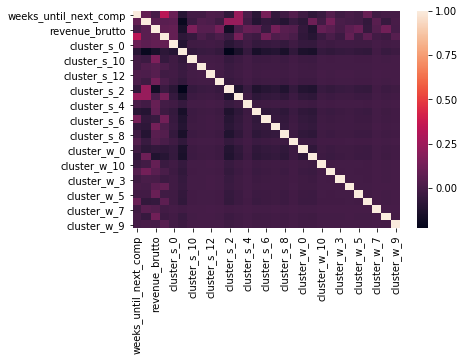

In [187]:
sns.heatmap(df_feats.corr())

In [188]:
X = df_feats.iloc[:, 1:].values
y = df_feats.iloc[:, 0].values
n_classes =  df_feats.iloc[:, 0].nunique()
n_classes

11

In [189]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)
y_norm = y.reshape(-1,1)

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.25, random_state=42)

In [192]:
reg = linear_model.LogisticRegression(class_weight='balanced').fit(X_train, y_train)
print('train', reg.score(X_train, y_train), 'test', reg.score(X_test, y_test)) 
acc = metrics.accuracy_score(y_train, reg.predict(X_train).reshape(-1,1))
print('{}%'.format(round(acc * 100, 3)))
acc = metrics.accuracy_score(y_test, reg.predict(X_test).reshape(-1,1))
print('{}%'.format(round(acc * 100, 3)))

train 0.3130311614730878 test 0.2542372881355932
31.303%
25.424%


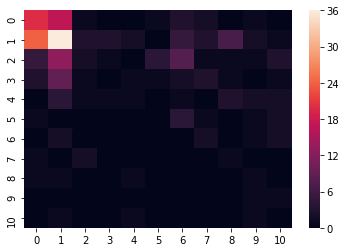

In [193]:
sns.heatmap(metrics.confusion_matrix(y_test, reg.predict(X_test).reshape(-1,1)))

In [194]:
sup = svm.SVC(class_weight='balanced', verbose=True, gamma='auto').fit(X_train, y_train)
print('train', sup.score(X_train, y_train), 'test', sup.score(X_test, y_test)) 
acc = metrics.accuracy_score(y_test, sup.predict(X_test).reshape(-1,1))
print('{}%'.format(round(acc * 100, 3)))

[LibSVM]train 0.28753541076487255 test 0.15254237288135594
15.254%


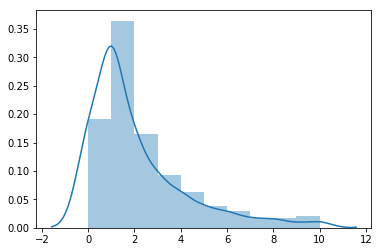

In [195]:
sns.distplot(y_test, bins=10)

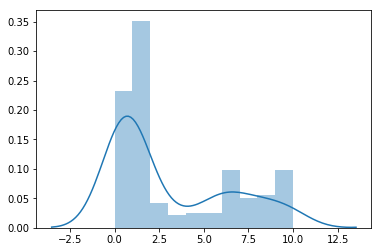

In [196]:
sns.distplot(reg.predict(X_test), bins=10)

In [197]:
neigh = KNeighborsClassifier(n_neighbors=40).fit(X_train, y_train) 
neigh.score(X_test, y_test)
print('train', neigh.score(X_train, y_train), 'test', neigh.score(X_test, y_test))
acc = metrics.f1_score(y_test, neigh.predict(X_test), average='weighted')
print('{}%'.format(round(acc * 100, 3)))

train 0.3526912181303116 test 0.3474576271186441
24.26%


In [198]:
frst = RandomForestClassifier(n_estimators=200, max_depth=4, class_weight='balanced').fit(X_train, y_train)
print('train', frst.score(X_train, y_train), 'test', frst.score(X_test, y_test))
acc = metrics.accuracy_score(y_test, frst.predict(X_test))
print('{}%'.format(round(acc * 100, 3)))

train 0.42209631728045327 test 0.19915254237288135
19.915%


In [201]:
mlp = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(10, 10), random_state=1, max_iter=1000, 
                    learning_rate_init=0.001, verbose=True, batch_size=1, alpha=0.9).fit(X_train, y_train)
print('train', mlp.score(X_train, y_train), 'test', mlp.score(X_test, y_test))
mlp.fit(X_train, y_train)
mlp.score(X_test, y_test)
acc = metrics.accuracy_score(y_test, mlp.predict(X_test))
print('{}%'.format(round(acc * 100, 3)))

train 0.509915014164306 test 0.3177966101694915
31.78%


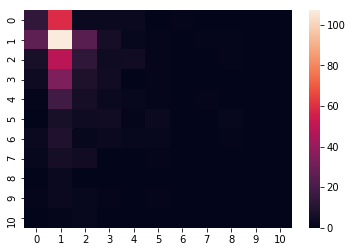

In [95]:
sns.heatmap(metrics.confusion_matrix(y_test, mlp.predict(X_test).reshape(-1,1)))

In [158]:
bys = linear_model.BayesianRidge().fit(X_train, y_train)
print('train', bys.score(X_train, y_train), 'test', bys.score(X_test, y_test))

train 0.2156261872508216 test 0.14938362071749645


In [159]:
bys.predict(X_test)

array([3.65009946, 1.44019854, 1.42086104, 1.94073174, 1.34003666,
       1.71009213, 1.45023868, 2.99152154, 1.53595884, 1.67876068,
       2.01575882, 2.81843208, 2.06752546, 1.59808498, 1.94798466,
       4.32596824, 1.52782511, 3.27270466, 4.54556466, 1.52792552,
       2.6546134 , 1.33035304, 1.64122524, 1.42629628, 3.03341956,
       3.10934575, 1.42982629, 1.75462409, 1.33113262, 3.89907063,
       2.53819018, 3.10177794, 2.06429941, 1.73182305, 1.90266141,
       1.705671  , 1.89287269, 1.79139006, 1.64683994, 1.75538621,
       2.8722723 , 2.6612435 , 3.11413434, 1.67219579, 1.67283151,
       1.37124371, 2.03295851, 1.40702465, 1.62085631, 3.70116229,
       2.53347659, 1.42239273, 1.71730247, 2.28024052, 1.42791787,
       2.83454837, 1.42468074, 1.67163544, 3.51685029, 4.15745233,
       1.55908383, 1.38736545, 1.21330558, 1.86639817, 2.40312989,
       3.56005058, 1.76616021, 3.18679684, 1.42749894, 3.34813857,
       1.18455174, 1.7675207 , 1.27276165, 3.79278459, 1.29996

In [77]:
model = hmm.GaussianHMM(n_components=3, covariance_type="full")